In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib



def load_spectrograms(dataset_path):
    X = []
    y = []

    # Iterate through subfolders in the dataset path
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)

        # Iterate through spectrogram files in the class folder
        for file_name in os.listdir(class_path):
            if file_name.endswith('.png'):
                file_path = os.path.join(class_path, file_name)

                # Read and resize the spectrogram image
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize the spectrogram image
                    img = cv2.resize(img, (224, 224))  # Adjust the size as needed

                    # Append the spectrogram and corresponding label to the lists
                    X.append(img)
                    y.append(class_folder)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Set the path to your 'specs' folder
dataset_path = '../data/recorded_specs'

# Load spectrograms and labels
X, y = load_spectrograms(dataset_path)

# Use LabelEncoder to convert string labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=17)

# Optionally, further split the training set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [8]:
X_train.shape, X_test.shape

((127, 224, 224), (32, 224, 224))

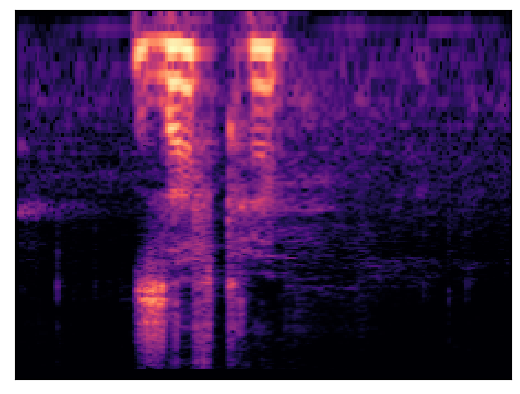

In [9]:
import librosa


# X_train[0], y_train[0]
librosa.display.specshow(X_train[0])

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# # Make predictions on the test set
# y_pred = model.predict_classes(X_test)

# # Decode numerical labels back to strings
# y_test_decoded = label_encoder.inverse_transform(y_test)
# y_pred_decoded = label_encoder.inverse_transform(y_pred)

# # Print classification report
# print(classification_report(y_test_decoded, y_pred_decoded))

Epoch 1/10
4/4 [==============================] - 3s 611ms/step - loss: 118.7341 - accuracy: 0.4158 - val_loss: 12.1577 - val_accuracy: 0.6538
Epoch 2/10
4/4 [==============================] - 2s 515ms/step - loss: 18.1144 - accuracy: 0.3960 - val_loss: 8.0850 - val_accuracy: 0.1538
Epoch 3/10
4/4 [==============================] - 2s 486ms/step - loss: 2.8529 - accuracy: 0.3960 - val_loss: 0.9027 - val_accuracy: 0.7308
Epoch 4/10
4/4 [==============================] - 2s 506ms/step - loss: 1.0320 - accuracy: 0.4653 - val_loss: 0.9975 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 2s 490ms/step - loss: 0.8348 - accuracy: 0.6040 - val_loss: 0.9074 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 2s 484ms/step - loss: 0.6367 - accuracy: 0.7327 - val_loss: 0.6612 - val_accuracy: 0.8462
Epoch 7/10
4/4 [==============================] - 2s 483ms/step - loss: 0.3661 - accuracy: 0.8911 - val_loss: 0.6599 - val_accuracy: 0.8462
Epoch 8/10
4/4 [

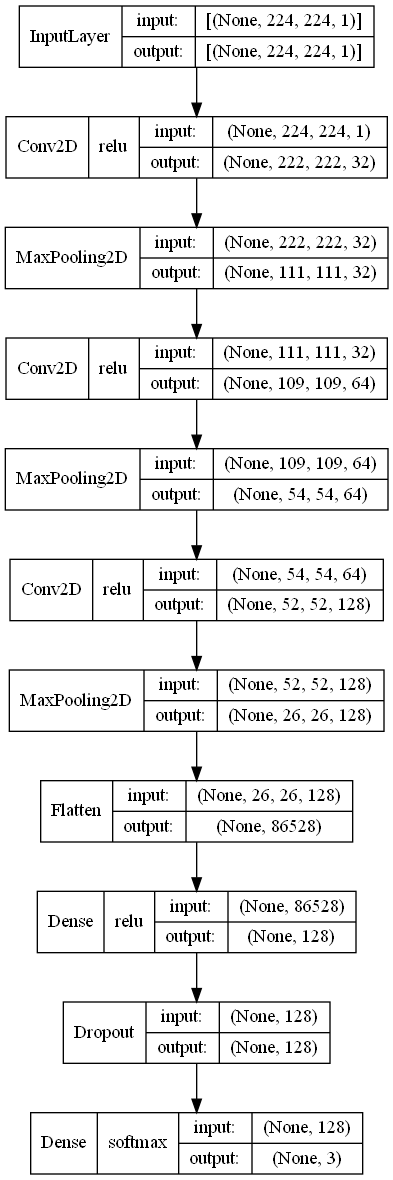

In [4]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

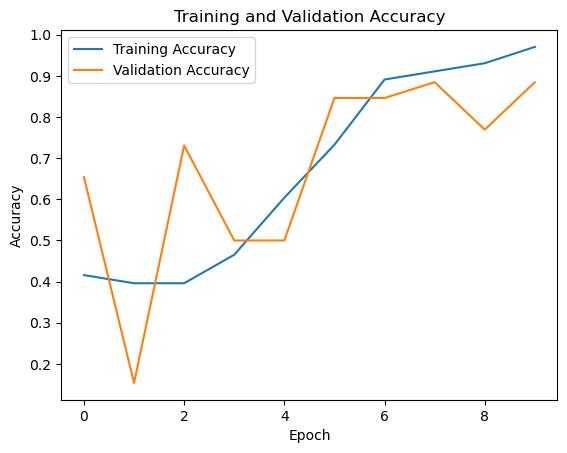

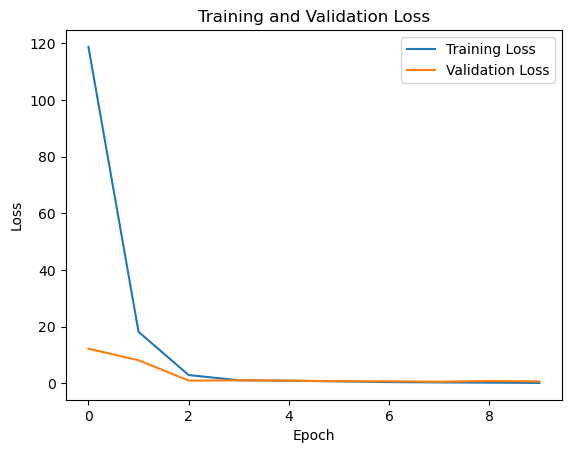

In [11]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode numerical labels back to strings
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print classification report
print(classification_report(y_test_decoded, y_pred_decoded))

1/1 [==============================] - 0s 277ms/step
              precision    recall  f1-score   support

        news       0.86      0.75      0.80         8
       today       0.63      0.92      0.75        13
    tomorrow       1.00      0.55      0.71        11

    accuracy                           0.75        32
   macro avg       0.83      0.74      0.75        32
weighted avg       0.81      0.75      0.75        32



In [13]:
# Save the trained model
model.save('cnn_on_records_model.h5')

# Save the LabelEncoder
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']